# Oil Production

In [13]:
# DATA MANIPULATION, Visualization, and stats
import pandas as pd
from glob import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
# Your current working directory should be ./mattwagon/oil_production_prediction/notebooks
os.getcwd()

'/home/pte/code/mattwagon/oil_production_prediction/notebooks'

In [15]:
# This filepath should work for all of us
# I have added 'raw_data' to .gitignore so it should never be pushed to the repo
path = os.path.join('..', 'data')

In [16]:
all_files = glob(os.path.join(path, "*.csv"))

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [17]:
df.shape

(5813, 189)

In [18]:
df.dtypes.Date

dtype('O')

In [19]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].dtype
df.Date[0]

Timestamp('2014-01-01 00:00:00+0100', tz='pytz.FixedOffset(60)')

In [20]:
# Removes the timezone aspect which makes the column easier to read but changes the date
df['Date'] = df['Date'].dt.tz_convert(None)
df['Date'].dtype
df.Date[0]

Timestamp('2013-12-31 23:00:00')

In [21]:
sorted_nan = df.isnull().sum().sort_values(ascending=False)
sorted_nan

Annulus Master Valve Status     5813
Qliq IPR                        5813
Qliq VLP/IPR                    5813
Qoil IPR                        5813
IWC Status                      5813
                                ... 
MPFM CF Liq                        0
MPFM CF GOR                        0
Downhole Gauge Status              0
Downhole Gauge Depth TVD MSL       0
GL WCT                             0
Length: 189, dtype: int64

In [22]:
features_drop = []
for feature, value in dict(sorted_nan).items():
    if value == len(df):
        features_drop.append(feature)

In [23]:
df.drop(columns=features_drop, inplace = True)

In [24]:
dic = {}
for feature, value in dict(sorted_nan).items():
    if value < len(df) and value > 0:
        dic[feature] = value

In [25]:
dic_2 = {}

for feature, value in dic.items():
    dic_2[feature] = round(value/len(df),2) 
    if dic_2[feature] > 0.3:
        features_drop.append(feature)

In [26]:
features_to_impute_check = []

for feature, value in dic_2.items():
    if value < 0.3:
        features_to_impute_check.append(feature)

In [27]:
remove = {"Sand Rate", "MPFM NTotal Count Rate", "MPFM N81 Count Rate", "MPFM N356 Count Rate", "MPFM N32 Count Rate", "MPFM GOR", "Downhole Gauge T", "Downhole Gauge P"}
 
features_to_impute = [f for f in features_to_impute_check if f not in remove]

In [28]:
df_to_impute = df[df.columns.intersection(features_to_impute)]

In [29]:
df_to_impute.head(5)

,WHT,WHP,Service Line P,Sand Raw,Qwat MPFM corrected,Qwat MPFM,Qoil MPFM corrected,Qoil MPFM,Qliq MPFM corrected,Qliq MPFM,...,Manifold T,Manifold P,Jumper T,Choke Opening Calc2,Choke Opening Calc1,Choke Opening,Choke Measured,Choke CCR,Choke Calculated,Annulus P
0,49.424992,81.824165,126.140625,5171.749023,11951.814813,11951.814813,17091.463968,17091.463968,29043.278780,29043.278780,...,NaN,71.863434,NaN,83.5,83.333336,84.450676,84.450676,83.5,83.333336,150.288574
1,49.437538,81.227585,118.089706,5170.277832,11774.075448,11774.075448,17144.338457,17144.338457,28918.413905,28918.413905,...,NaN,71.972305,NaN,83.5,83.333336,84.237045,84.237045,83.5,83.333336,150.264343
2,49.429569,81.635826,113.882248,5193.926758,12074.141344,12074.141344,17061.866461,17061.866461,29136.007805,29136.007805,...,NaN,71.881966,NaN,83.5,83.333336,84.328468,84.328468,83.5,83.333336,150.299820
3,49.413170,81.485970,112.659027,5213.230469,12086.639578,12086.639578,17176.929228,17176.929228,29263.568807,29263.568807,...,NaN,71.968727,NaN,83.5,83.333336,84.363831,84.363831,83.5,83.333336,150.224533
4,49.419609,81.495781,112.002983,5217.773438,11829.115131,11829.115131,16896.460639,16896.460639,28725.575770,28725.575770,...,NaN,71.681068,NaN,83.5,83.333336,84.106171,84.106171,83.5,83.333336,150.108139


In [30]:
df_to_impute.describe()

,WHT,WHP,Service Line P,Sand Raw,Qwat MPFM corrected,Qwat MPFM,Qoil MPFM corrected,Qoil MPFM,Qliq MPFM corrected,Qliq MPFM,...,Manifold T,Manifold P,Jumper T,Choke Opening Calc2,Choke Opening Calc1,Choke Opening,Choke Measured,Choke CCR,Choke Calculated,Annulus P
count,5642.000000,5228.000000,5521.000000,5747.000000,5664.000000,5642.000000,5664.000000,5633.000000,5664.000000,5628.000000,...,5128.000000,5782.000000,4835.000000,5785.000000,5780.000000,5753.000000,5753.000000,5785.000000,5780.000000,5751.000000
mean,48.831748,82.685001,124.365437,5434.123375,10354.114095,10422.348374,15589.131906,15706.773138,25943.246002,26133.836456,...,48.723259,67.082424,47.728970,75.994536,75.990730,76.907927,76.907927,75.994536,75.990730,139.652154
std,8.227372,19.358646,32.454476,879.564456,6611.698415,6573.008235,9030.323334,8955.454985,8292.619083,8013.385746,...,9.986042,13.047429,8.744576,20.610524,20.513595,19.849258,19.849258,20.610524,20.513595,24.360330
min,2.044475,1.013250,58.107376,2744.435303,-11.831733,-11.831733,0.000000,0.000000,0.000000,0.000000,...,-1.088101,1.000000,-8.794330,0.000000,0.000000,-0.251513,-0.251513,0.000000,0.000000,18.328125
25%,49.698901,72.185286,105.313896,4847.917725,3291.518388,3417.593842,9691.354946,9731.330410,22872.243590,22998.066174,...,49.200542,64.776993,48.669762,69.500000,69.902908,71.024460,71.024460,69.500000,69.902908,114.920982
50%,51.247467,78.146263,109.413887,5084.182129,12935.184728,12960.072938,13932.108410,14065.431937,26524.630513,26572.039040,...,51.940947,69.046879,51.085567,76.000000,76.213593,76.917267,76.917267,76.000000,76.213593,150.246353
75%,51.716765,83.912359,129.247482,5785.894531,15590.195567,15601.058678,18567.139606,18599.235723,31155.054050,31173.918848,...,53.746908,72.578142,51.790573,88.000000,87.864075,89.496338,89.496338,88.000000,87.864075,157.888649
max,52.393002,216.446396,272.471619,12071.355469,25903.980632,25903.980632,49223.595339,49223.595339,49676.388581,49676.388581,...,54.276535,140.115250,52.241966,100.300003,100.000000,101.011047,101.011047,100.300003,100.000000,168.035065


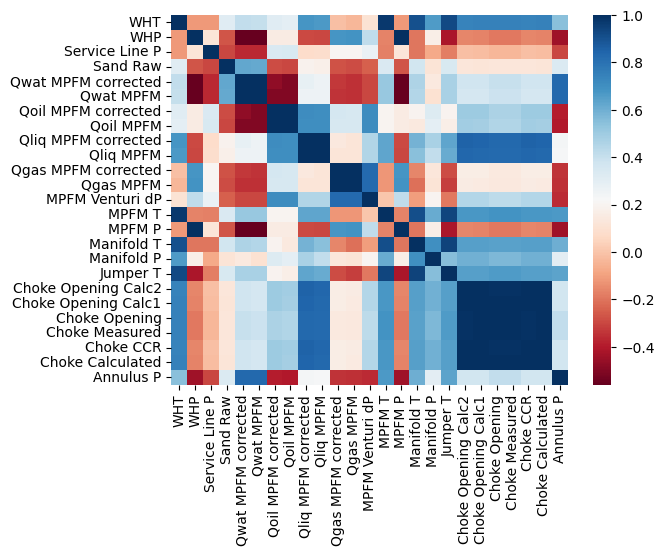

In [31]:
# Pairwise correlation
sns.heatmap(df_to_impute.corr(), cmap='RdBu')
plt.show()

A lot of the 'Choke' features seem to be duplicates of each other or at least extremely similar

Qwat and Annulus P features show strong negative correlation towards our target feature

### Let's look into the choke features

In [32]:
# Get list of choke features
choke_cols = [col for col in df_to_impute.columns if 'Choke' in col]
choke_cols

['Choke Opening Calc2',
 'Choke Opening Calc1',
 'Choke Opening',
 'Choke Measured',
 'Choke CCR',
 'Choke Calculated']

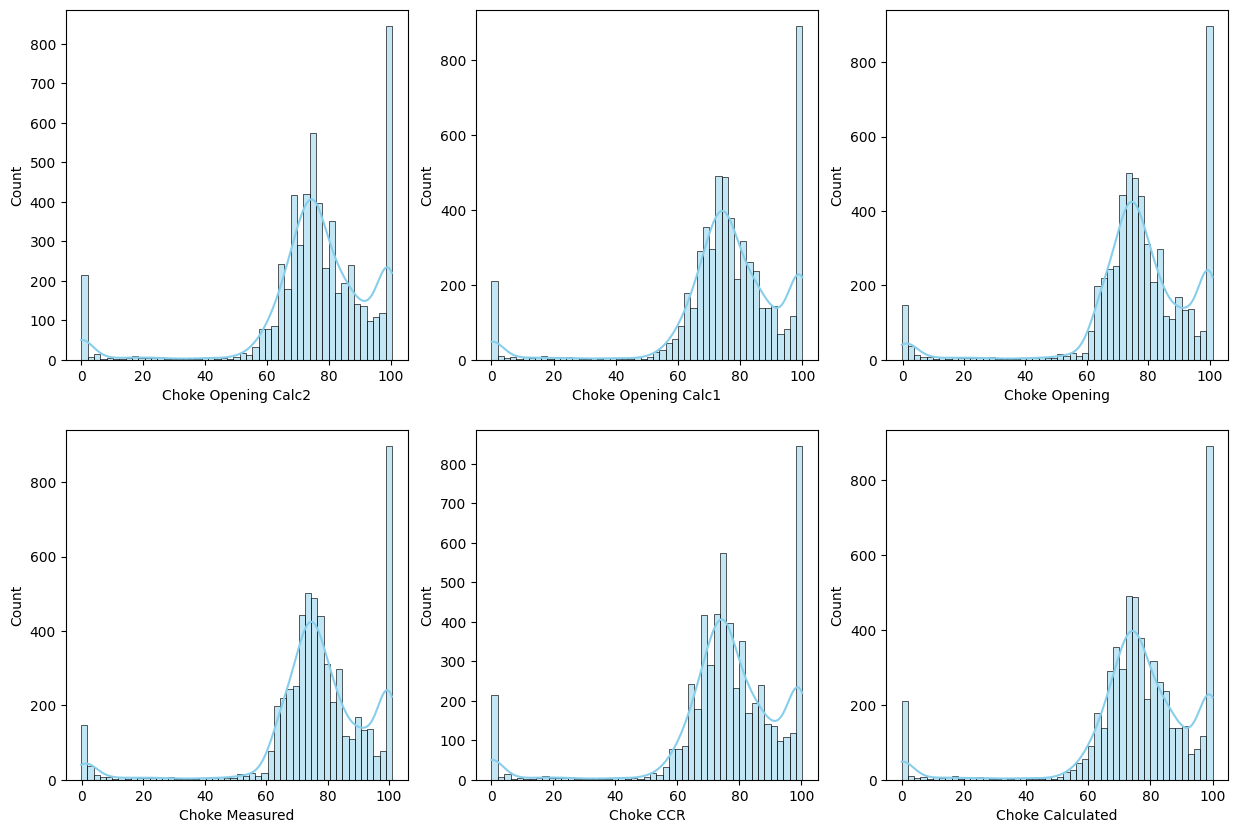

In [33]:
# Visual look at distribution of choke data to check for any notable differences
f, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, feature in zip(axes.flat, df_to_impute[choke_cols]):
    sns.histplot(df_to_impute[feature] , color="skyblue", kde=True, ax=ax)

Looks like there is subtle differences in the data

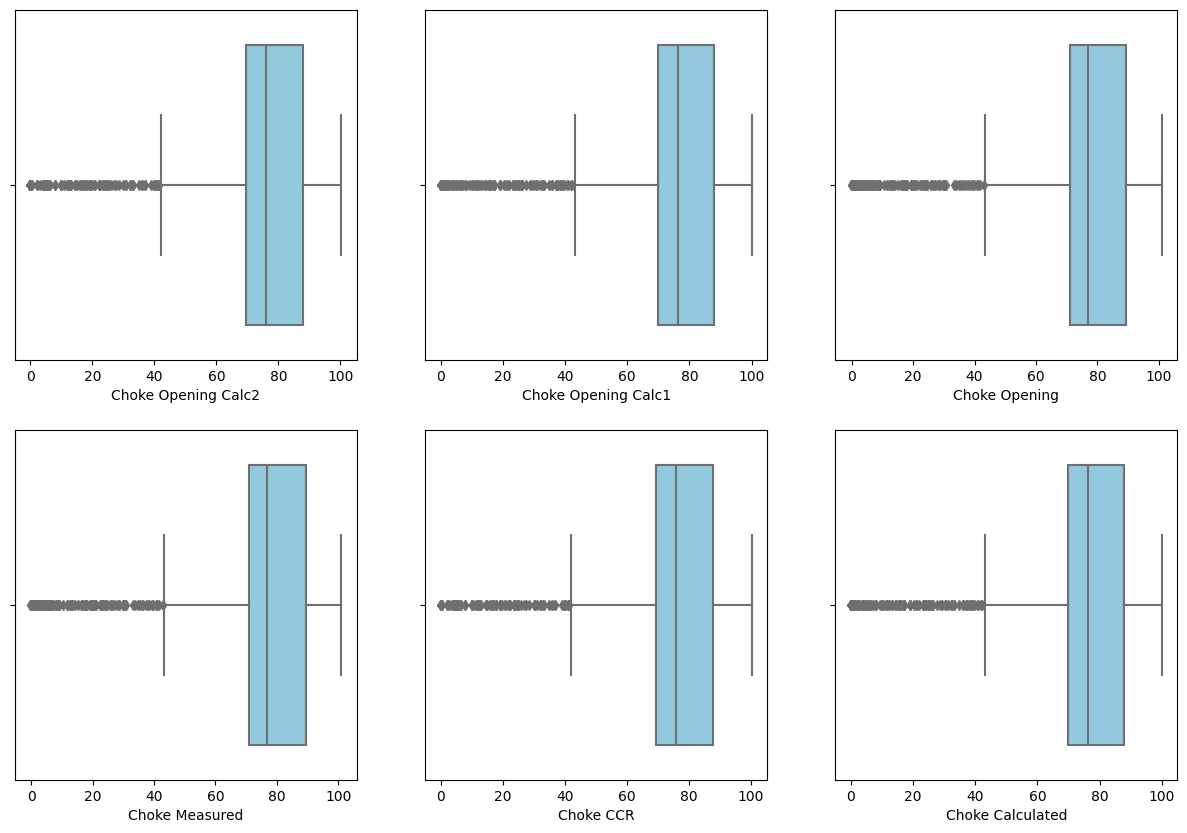

In [34]:
# Visual check for outliers
f, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, feature in zip(axes.flat, df_to_impute[choke_cols]):
    sns.boxplot(data=df_to_impute, x=feature, color="skyblue", ax=ax)

No obvious outliers or differences between features

The features look like pairs (Choke Opening calc 1 - Choke Calculated), (Choke Opening - Choke Measured) and (Choke CCR - Choke Opening Calc 2)

We should drop one of each pair to avoid multicollinearity (I think)

Unsure whether the features skewness will affect scaling

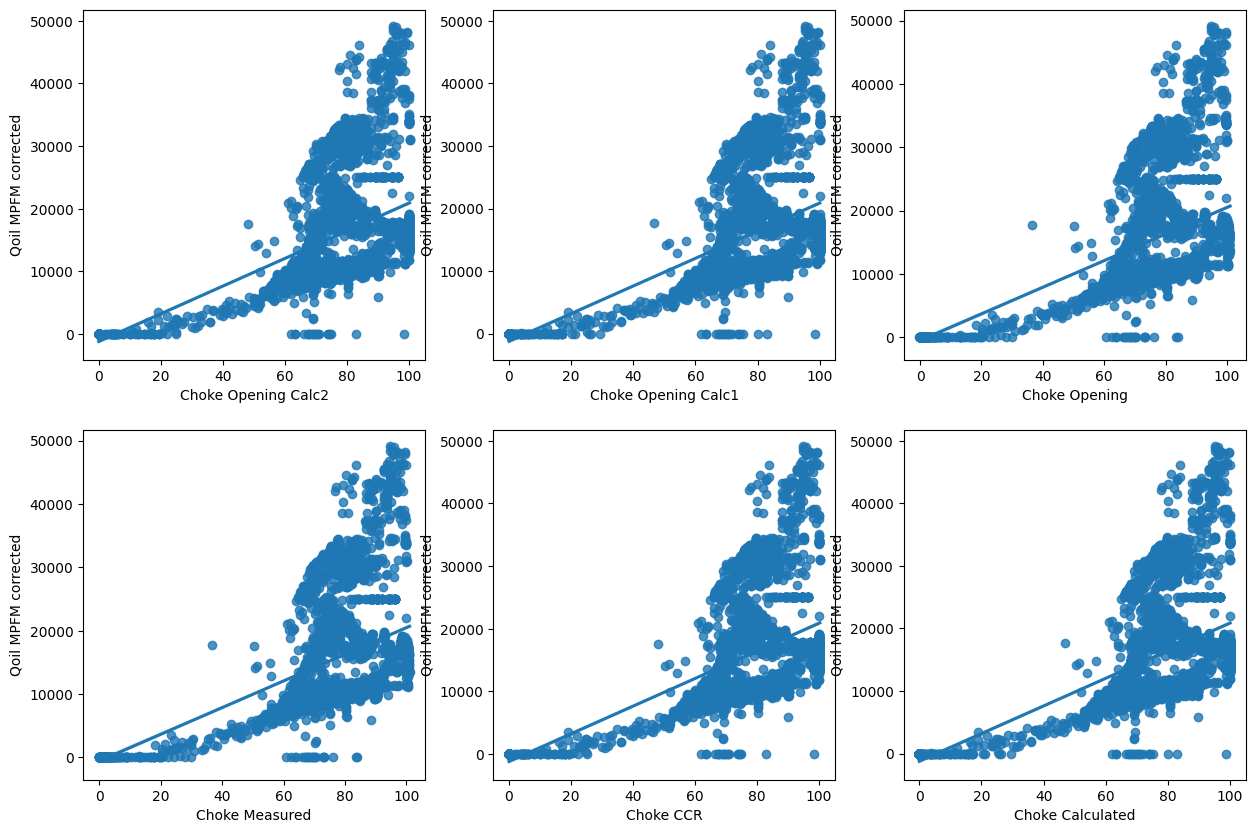

In [35]:
# Regression look at the regression of the choke features and our target
f, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, feature in zip(axes.flat, choke_cols):
    sns.regplot(data=df_to_impute, x=feature, y=df_to_impute['Qoil MPFM corrected'], ax=ax)

### Look at the negative correlated features

In [37]:
neg_corr_features = df_to_impute[['Qwat MPFM', 'Qwat MPFM corrected', 'Annulus P']]

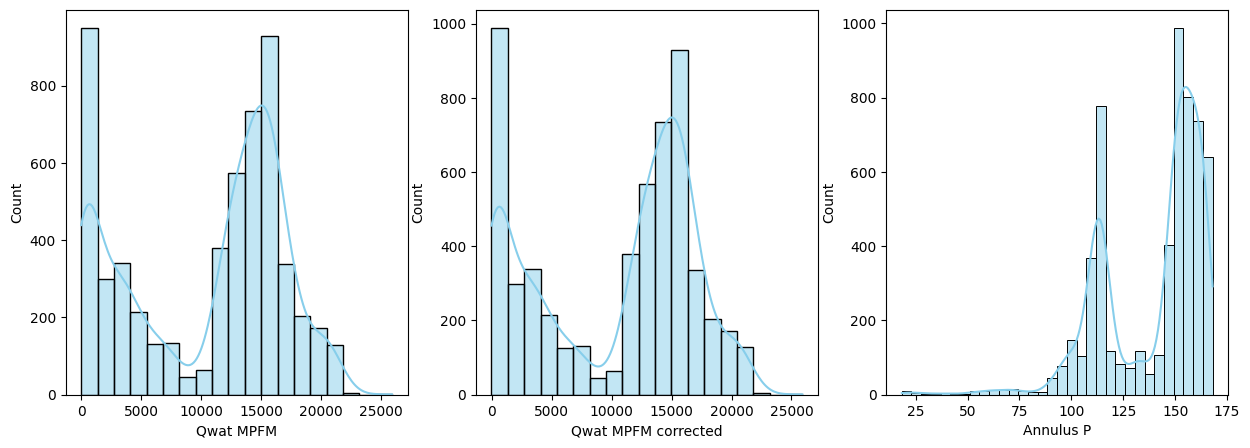

In [38]:
# Visual look at distribution of negatively correlated data
f, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, feature in zip(axes.flat, neg_corr_features):
    sns.histplot(df_to_impute[feature] , color="skyblue", kde=True, ax=ax)

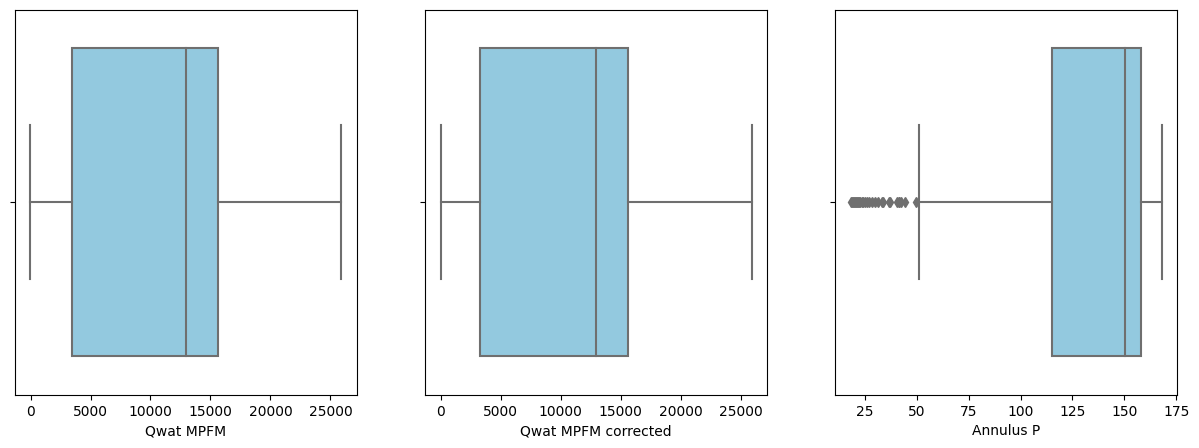

In [39]:
# Visual check for outliers
f, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, feature in zip(axes.flat, neg_corr_features):
    sns.boxplot(data=neg_corr_features, x=feature, color="skyblue", ax=ax)

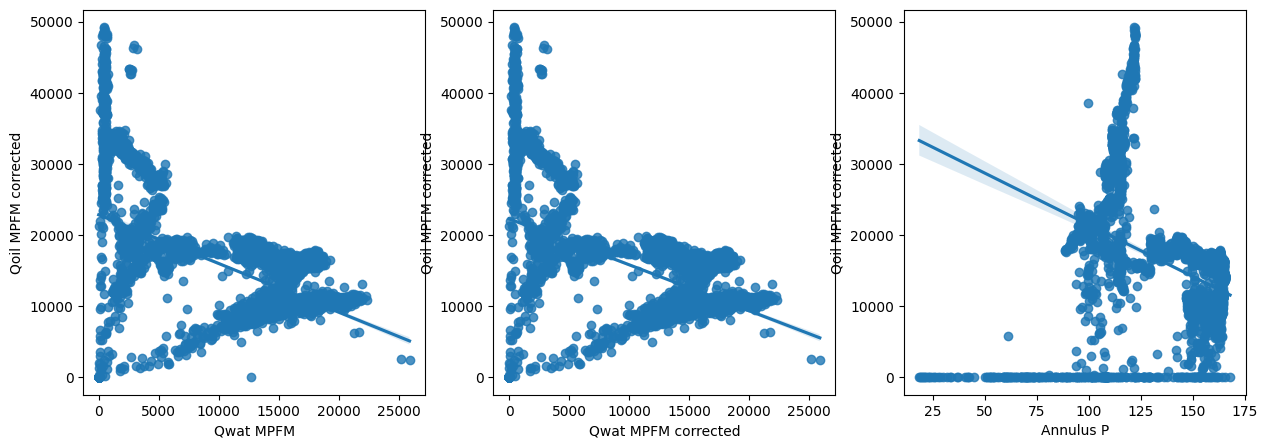

In [44]:
# Visual look at the regression of negative correlated features and our target
f, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, feature in zip(axes.flat, neg_corr_features):
    sns.regplot(data=df_to_impute, x=feature, y=df_to_impute['Qoil MPFM corrected'], ax=ax)

#### Look at he positive correaltion between Annulus P and Qwat

<Axes: xlabel='Annulus P', ylabel='Qwat MPFM'>

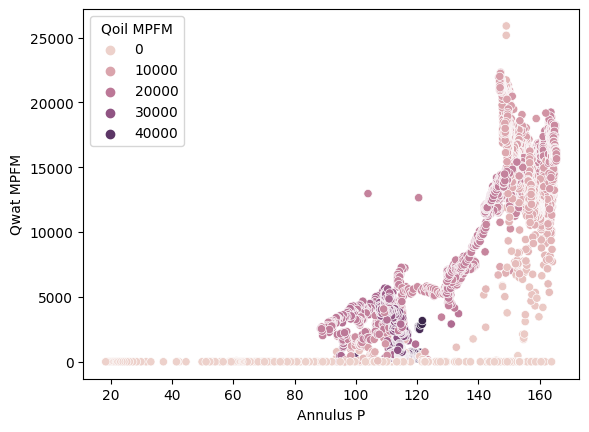

In [46]:
sns.scatterplot(data=df_to_impute, x='Annulus P', y='Qwat MPFM')